<a href="https://colab.research.google.com/github/brunotagoncalves/MeLi_2021_demand_prediction/blob/main/meli_EDA_2nd_sub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read Data 

In [1]:
!wget https://meli-data-challenge.s3.amazonaws.com/2021/test_data.csv
!wget https://meli-data-challenge.s3.amazonaws.com/2021/train_data.parquet
!wget https://meli-data-challenge.s3.amazonaws.com/2021/items_static_metadata_full.jl
!wget https://meli-data-challenge.s3.amazonaws.com/2021/sample_submission.csv.gz

--2021-07-21 11:14:46--  https://meli-data-challenge.s3.amazonaws.com/2021/test_data.csv
Resolving meli-data-challenge.s3.amazonaws.com (meli-data-challenge.s3.amazonaws.com)... 52.217.131.121
Connecting to meli-data-challenge.s3.amazonaws.com (meli-data-challenge.s3.amazonaws.com)|52.217.131.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5075979 (4.8M) [text/csv]
Saving to: ‘test_data.csv’

test_data.csv       100%[===================>]   4.84M  3.30MB/s    in 1.5s    

2021-07-21 11:14:48 (3.30 MB/s) - ‘test_data.csv’ saved [5075979/5075979]

--2021-07-21 11:14:48--  https://meli-data-challenge.s3.amazonaws.com/2021/train_data.parquet
Resolving meli-data-challenge.s3.amazonaws.com (meli-data-challenge.s3.amazonaws.com)... 52.217.131.121
Connecting to meli-data-challenge.s3.amazonaws.com (meli-data-challenge.s3.amazonaws.com)|52.217.131.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81456239 (78M) [application/x-www-form-ur

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget http://www-eu.apache.org/dist/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz 
!wget -P spark_tgz/ http://www-eu.apache.org/dist/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz

--2021-07-21 11:18:20--  http://www-eu.apache.org/dist/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
Resolving www-eu.apache.org (www-eu.apache.org)... 95.216.26.30, 2a01:4f9:2a:1a61::2
Connecting to www-eu.apache.org (www-eu.apache.org)|95.216.26.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloads.apache.org/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz [following]
--2021-07-21 11:18:20--  https://downloads.apache.org/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
Resolving downloads.apache.org (downloads.apache.org)... 135.181.209.10, 88.99.95.219, 135.181.214.104, ...
Connecting to downloads.apache.org (downloads.apache.org)|135.181.209.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 235899716 (225M) [application/x-gzip]
Saving to: ‘spark_tgz/spark-2.4.8-bin-hadoop2.7.tgz’

spark-2.4.8-bin-had 100%[===================>] 224.97M  10.4MB/s    in 23s     

2021-07-21 11:18:45 (9.69 MB/s) - ‘spark_tgz/spark

In [3]:
!tar -xf spark_tgz/spark-2.4.8-bin-hadoop2.7.tgz -C spark_tgz/
!pip install -q findspark
!pip install -q pyspark

     |████████████████████████████████| 212.4 MB 63 kB/s 
     |████████████████████████████████| 198 kB 54.4 MB/s 


In [1]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark_tgz/spark-2.4.8-bin-hadoop2.7"

In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [3]:
import pandas as pd 
import numpy as np


In [7]:
df = spark.read.format('parquet').load("train_data.parquet")

In [8]:
df.count()

37660279

In [40]:
df.createOrReplaceTempView('df')

In [41]:
spark.sql("""
SELECT df.*
  ,minutes_active - lag(minutes_active,1) over (partition by sku order by date asc) diff_minutes_active
  ,(CASE WHEN minutes_active - lag(minutes_active,1) over (partition by sku order by date asc) < 0 THEN 'Ruptura'END) Ruptura
  ,(CASE WHEN minutes_active - lag(minutes_active,1) over (partition by sku order by date asc) > 0 THEN 'Estoque'END) Estoque
  
FROM df
--where sku = 645793
--order by sku, date
""").createOrReplaceTempView('df_re')

In [42]:
spark.sql("""
SELECT df_re.*
  --,minutes_active - lag(minutes_active,1) over (partition by sku order by date asc) diff_minutes_active
  --,CASE WHEN minutes_active - lag(minutes_active,1) over (partition by sku order by date asc) < 0 THEN 'Ruptura'END Ruptura
  --,CASE WHEN minutes_active - lag(minutes_active,1) over (partition by sku order by date asc) > 0 THEN 'Estoque'END Estoque
  --,max(Ruptura) over (partition by sku order by date asc) Ruptura
  --,max(Estoque) over (partition by sku order by date asc) Estoque
  ,CASE WHEN Ruptura is null and Estoque is null and minutes_active>0 and diff_minutes_active is null then 'Estoque'
        --WHEN Estoque is not null then 'Estoque'
        WHEN minutes_active = diff_minutes_active	and Estoque is not null then 'Estoque'
        --WHEN Ruptura is not null and Estoque is null then 'Ruptura'
        WHEN Ruptura is not null and Estoque is null and minutes_active=0  then 'Ruptura'
        

        END STATUS_RUPTURA
FROM df_re
--where sku = 645793
--order by sku, date
""").createOrReplaceTempView('df_re')#.toPandas()

In [43]:
spark.sql("""
SELECT df_re.*
  ,COUNT(CASE WHEN STATUS_RUPTURA IS NOT NULL THEN 1 END) over (partition by sku order by date ) ciclo_ruptura
FROM df_re
--where sku = 645793
--order by sku, date
""").createOrReplaceTempView('df_re')#.toPandas()

In [44]:
spark.sql("""
SELECT df_re.*
  ,SUM(sold_quantity) over (partition by sku,ciclo_ruptura order by date desc) sum_sold_quantity 
  ,avg(case when sold_quantity >0 then current_price end) over (partition by sku,ciclo_ruptura order by date desc) avg_current_price 
  ,round(SUM(minutes_active) over (partition by sku,ciclo_ruptura order by date desc) /60/24 + 0.5,0) days_active 
FROM df_re
--where sku = 645793
--order by sku, date
""").createOrReplaceTempView('df_re')#.toPandas()

In [46]:
spark.sql("""
SELECT df_re.*
  
  ,min(case when avg_current_price is not null then days_active end) over (partition by sku,ciclo_ruptura order by date desc)=1 FLG_ruptura 
FROM df_re
--where sku = 645793
--order by sku, date
""").filter('FLG_ruptura=True').drop(*['date','sold_quantity','minutes_active','diff_minutes_active',	'Ruptura',	'Estoque',	'STATUS_RUPTURA',	'ciclo_ruptura']).createOrReplaceTempView('df_final')#.toPandas()

In [47]:
%%time
spark.sql("""
SELECT *
FROM df_final
""").write.mode('overwrite').format('parquet').save('data/tabelao/')

In [4]:
df = spark.read.format('parquet').load('data/tabelao/')

In [5]:
df.count()

9909204

In [6]:
df.repartition(1).write.mode('overwrite').format('parquet').save('data/tabela_final/')

In [4]:
df = pd.read_parquet('part-00000-72845926-8ef8-4ae2-87d1-00cbe9b6399c-c000.snappy.parquet')
#pd_df = df.toPandas()

In [5]:
df.head()

,sku,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,sum_sold_quantity,avg_current_price,days_active,FLG_ruptura
0,264,1151.69,MEX,premium,fulfillment,free_shipping,6,1151.690,1.0,True
1,264,1151.69,MEX,premium,fulfillment,free_shipping,19,1151.690,2.0,True
2,264,1151.69,MEX,premium,fulfillment,free_shipping,24,1151.690,3.0,True
3,264,1087.73,MEX,premium,fulfillment,free_shipping,33,1135.700,4.0,True
4,264,1095.98,MEX,premium,fulfillment,free_shipping,53,1127.756,5.0,True


In [6]:
df.shape

(9909204, 10)

In [7]:
df.loc[df.sku==264,:]

,sku,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,sum_sold_quantity,avg_current_price,days_active,FLG_ruptura
0,264,1151.69,MEX,premium,fulfillment,free_shipping,6,1151.690000,1.0,True
1,264,1151.69,MEX,premium,fulfillment,free_shipping,19,1151.690000,2.0,True
2,264,1151.69,MEX,premium,fulfillment,free_shipping,24,1151.690000,3.0,True
3,264,1087.73,MEX,premium,fulfillment,free_shipping,33,1135.700000,4.0,True
4,264,1095.98,MEX,premium,fulfillment,free_shipping,53,1127.756000,5.0,True
5,264,1054.85,MEX,premium,fulfillment,free_shipping,64,1115.605000,6.0,True
6,264,1061.28,MEX,premium,fulfillment,free_shipping,84,1107.844286,7.0,True
7,264,1061.28,MEX,premium,fulfillment,free_shipping,93,1102.023750,8.0,True
8,264,1039.84,MEX,premium,fulfillment,free_shipping,107,1095.114444,9.0,True
9,264,1020.93,MEX,premium,fulfillment,free_shipping,127,1087.696000,10.0,True


In [20]:
g_df = df.groupby([i for i in df.columns if i !='days_active'],as_index=False).days_active.mean().round(0)

In [21]:
df_test = pd.read_csv('test_data.csv')


In [22]:

pd.merge(df_test,g_df,left_on=['sku','target_stock'],right_on=['sku','sum_sold_quantity']).sku.count(),df_test.count()

(152949, sku             551472
 target_stock    551472
 dtype: int64)

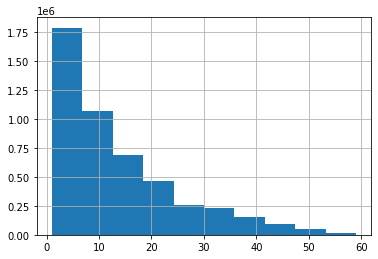

In [23]:
g_df.days_active.hist()

In [24]:
!pip install catboost

In [25]:
from catboost import Pool, CatBoostClassifier
g_df

,sku,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,sum_sold_quantity,avg_current_price,FLG_ruptura,days_active
0,1,136.0,REA,premium,fulfillment,free_shipping,1,136.0,True,1.0
1,1,136.0,REA,premium,fulfillment,free_shipping,2,136.0,True,2.0
2,1,136.0,REA,premium,fulfillment,free_shipping,4,136.0,True,3.0
3,1,136.0,REA,premium,fulfillment,free_shipping,7,136.0,True,5.0
4,1,136.0,REA,premium,fulfillment,free_shipping,10,136.0,True,8.0
...,...,...,...,...,...,...,...,...,...,...
4808979,660915,129.0,MEX,classic,fulfillment,paid_shipping,30,121.0,True,11.0
4808980,660915,129.0,MEX,classic,fulfillment,paid_shipping,34,122.0,True,12.0
4808981,660915,146.0,MEX,premium,fulfillment,paid_shipping,34,122.0,True,13.0
4808982,660915,146.0,MEX,premium,fulfillment,paid_shipping,36,124.0,True,14.0


In [14]:
#g_df = pd.merge(g_df,df_test,left_on='sku_',right_on='sku', how='inner')

In [44]:
vars = ['sku',
 'sum_sold_quantity'
 ]
cat_vars =  ['sku'
 ]

In [27]:
g_df.loc[:,'days_active'].apply(lambda x : x if x < 30. else 30.).round().astype(int)

0           1
1           2
2           3
3           5
4           8
           ..
4808979    11
4808980    12
4808981    13
4808982    14
4808983    15
Name: days_active, Length: 4808984, dtype: int64

In [ ]:
# initialize data
train_data = g_df.loc[:,vars].sample(frac=.01,random_state=123)
train_label = g_df.loc[:,'days_active'].apply(lambda x : x if x<30. else 30.).round().astype(int).sample(frac=.01,random_state=123)
#test_data = g_df.loc[~g_df.sku.isnull(),'current_price_count':'shipping_payment_shipping_payment']#.sample(frac=.1,random_state=1234)
# initialize Pool
train_pool = Pool(train_data, 
                  train_label, 
                  cat_features=cat_vars)
#test_pool = Pool(test_data)#, 
                 #cat_features=[0,2,5]) 

# specify the training parameters 
model = CatBoostClassifier()#n_estimators=100,learning_rate=0.1)
#train the model
model.fit(train_pool)
# make the prediction using the resulting model



Learning rate set to 0.096407
0:	learn: 3.2507280	total: 3.06s	remaining: 50m 57s
1:	learn: 3.1779254	total: 6.06s	remaining: 50m 24s
2:	learn: 3.1278081	total: 9.18s	remaining: 50m 51s
3:	learn: 3.0863546	total: 12.2s	remaining: 50m 35s
4:	learn: 3.0542606	total: 14.1s	remaining: 46m 42s
5:	learn: 3.0292645	total: 16.9s	remaining: 46m 43s
6:	learn: 3.0082270	total: 18.8s	remaining: 44m 23s
7:	learn: 2.9905452	total: 21.6s	remaining: 44m 40s
8:	learn: 2.9752787	total: 24.4s	remaining: 44m 51s
9:	learn: 2.9630263	total: 27.3s	remaining: 45m 1s
10:	learn: 2.9522512	total: 30.1s	remaining: 45m 7s
11:	learn: 2.9430773	total: 33s	remaining: 45m 13s
12:	learn: 2.9350608	total: 35.8s	remaining: 45m 15s
13:	learn: 2.9289191	total: 37.4s	remaining: 43m 53s
14:	learn: 2.9235603	total: 40.1s	remaining: 43m 54s
15:	learn: 2.9187624	total: 42.9s	remaining: 43m 58s
16:	learn: 2.9140092	total: 45.7s	remaining: 44m 1s
17:	learn: 2.9104462	total: 48.5s	remaining: 44m 3s
18:	learn: 2.9068378	total: 51.2

In [30]:
g_df.loc[:,vars].head()

,sku,sum_sold_quantity,avg_current_price
0,1,1,136.0
1,1,2,136.0
2,1,4,136.0
3,1,7,136.0
4,1,10,136.0


In [31]:
df_test.loc[:,:].head()

,sku,target_stock
0,464801,3
1,645793,4
2,99516,8
3,538100,8
4,557191,10


In [32]:
df_test.loc[:,'sum_sold_quantity']=df_test.loc[:,'target_stock']

In [33]:
g_df.loc[:,'total_money'] = g_df.avg_current_price*g_df.sum_sold_quantity
test = g_df.groupby('sku',as_index=False).agg({'total_money':'sum','sum_sold_quantity':'sum'})

In [34]:
df_spark = spark.read.format('parquet').load("train_data.parquet")

In [35]:
import pyspark.sql.functions as F

In [36]:
test = df_spark.withColumn('total_day',F.when(df_spark.sold_quantity>0,df_spark.sold_quantity*df_spark.current_price).otherwise(df_spark.current_price)).groupby('sku').sum().select(*['sku','sum(total_day)','sum(sold_quantity)']).toPandas()

In [37]:
test.loc[:,'avg_current_price'] = test.loc[:,'sum(total_day)']/test.loc[:,'sum(sold_quantity)'].apply(lambda x : x if x>0 else 1)

In [38]:
df_test

,sku,target_stock,sum_sold_quantity
0,464801,3,3
1,645793,4,4
2,99516,8,8
3,538100,8,8
4,557191,10,10
...,...,...,...
551467,129187,8,8
551468,6707,30,30
551469,170355,3,3
551470,246568,2,2


In [39]:
#df_test.join(test,on='sku')
df_test = pd.merge(df_test,test,on=['sku'])#,suffixes=('_x', '_y'))

In [40]:
test_data = df_test.loc[:,vars]
test_pool = Pool(test_data,
                 cat_features=cat_vars) 


In [41]:
pd.DataFrame(model.predict(test_data)).describe()#.hist()

,0
count,551472.000000
mean,11.730050
std,12.799138
min,1.000000
25%,2.000000
50%,4.000000
75%,30.000000
max,30.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3fe03c9490>]],
      dtype=object)

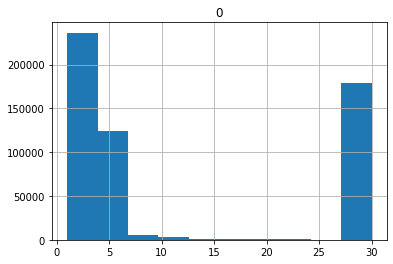

In [42]:
pd.DataFrame(model.predict(test_data)).hist()

In [43]:
pd.DataFrame(model.predict_proba(test_data)).round(4).to_csv("test_inner.csv.gz",compression='gzip',index=False,header=False)

In [ ]:
pd